In [1]:
import ast

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import math

from transformers import AutoModel

from sklearn.model_selection import train_test_split

c:\Users\Telha Bilal\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data_df = pd.read_parquet('https://huggingface.co/datasets/alielfilali01/Hindawi-Books-dataset/resolve/main/data/train-00001-of-00003-eb5652255f7d127f.parquet?download=true')
# data_df.dropna(subset=['AuthorName', 'ChapterText'], inplace=True, how='any')
# print(len(data_df))
# data_df.columns

In [2]:
data_df = pd.read_csv('data.csv')
print(len(data_df))
data_df.columns

15140


Index(['BookLink', 'BookName', 'AuthorName', 'AboutBook', 'ChapterLink',
       'ChapterName', 'ChapterText', 'AboutAuthor', 'chapter_words'],
      dtype='object')

In [3]:
data_df['chapter_words'] = data_df['ChapterText'].apply(lambda x: len(x.split()))
data_df['chapter_words'].describe()

count    15140.000000
mean      2056.145839
std       3531.697982
min          1.000000
25%        464.000000
50%       1043.000000
75%       2362.250000
max      91100.000000
Name: chapter_words, dtype: float64

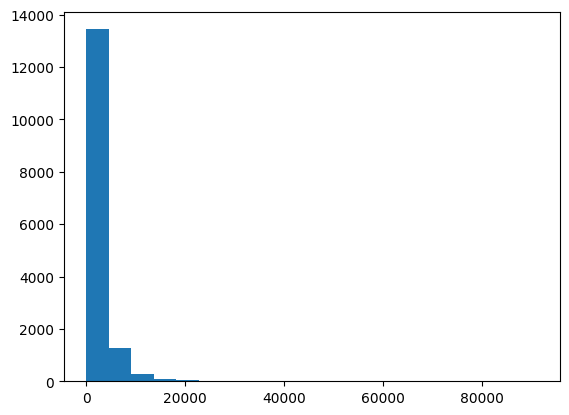

In [4]:
plt.hist(data_df['chapter_words'], bins=20)
plt.show()

In [5]:
len_filtered_df = data_df[(data_df['chapter_words'] >= 1)]

In [6]:
len(len_filtered_df)

15140

### Find the authors with highest book counts and top 10 chapter counts

In [7]:
len_filtered_df.groupby('AuthorName')['BookName'].nunique().sort_values(ascending=False)[:10]

AuthorName
آرثر كونان دويل        49
نوال السعداوي          33
إدوارد بيدج ميتشل      30
هربرت جورج ويلز        27
يوسف إدريس             27
زكي نجيب محمود         21
سليم حسن               18
فؤاد زكريا             18
جِلبرت كيث تشسترتون    16
عباس محمود العقاد      16
Name: BookName, dtype: int64

In [8]:
# author_chapter_counts = len_filtered_df['AuthorName'].value_counts()[:10]
# author_book_counts = len_filtered_df.groupby('AuthorName')['BookName'].nunique().sort_values(ascending=False)[:10]


author_chapter_counts = len_filtered_df.groupby('AuthorName')['ChapterName'].nunique().sort_values(ascending=False)[:10]
author_book_counts = len_filtered_df[len_filtered_df['AuthorName'].isin(author_chapter_counts.index)].groupby('AuthorName')['BookName'].nunique().sort_values(ascending=False)[:10]

In [9]:
author_book_counts

AuthorName
نوال السعداوي         33
يوسف إدريس            27
زكي نجيب محمود        21
سليم حسن              18
عباس محمود العقاد     16
شوقي عبد الحكيم       14
ثورنتون دبليو برجس     9
نقولا حداد             9
محمد لطفي جمعة         5
أبو حيان التوحيدي      2
Name: BookName, dtype: int64

In [10]:
chosen_author_df = data_df[data_df['AuthorName'].isin(author_book_counts.index)]

### Process the data: filter the length of texts(in words) + make sure chapters are taken equally from books

In [11]:
# len_adjusted_subdfs = []
# for author_name, group in chosen_author_df.groupby('AuthorName'):
#     sample_df = group.sample(author_chapter_counts.min()).copy()
#     sample_df['ChapterText'] = sample_df['ChapterText'].str.split().apply(lambda x: ' '.join(x[:1500]))
#     len_adjusted_subdfs.append(sample_df)

target_rows_per_author = 200
len_adjusted_subdfs = []

for author_name, group_df1 in chosen_author_df.groupby('AuthorName'):

    n_samples_per_book = int(math.ceil((target_rows_per_author/author_book_counts[author_name])))

    for book_name, group_df2 in group_df1.groupby('BookName'):
        sample_len = min(n_samples_per_book, len(group_df2))
        sample_df = group_df2.sample(n=sample_len)
        sample_df['ChapterText'] = sample_df['ChapterText'].str.split().apply(lambda x: ' '.join(x[:1500]))
        len_adjusted_subdfs.append(sample_df)

In [12]:
chosen_author_df = pd.concat(len_adjusted_subdfs, ignore_index=True)

In [13]:
chosen_author_df['AuthorName'].value_counts()

سليم حسن              209
ثورنتون دبليو برجس    205
زكي نجيب محمود        198
نقولا حداد            194
نوال السعداوي         175
شوقي عبد الحكيم       170
عباس محمود العقاد     168
يوسف إدريس            155
محمد لطفي جمعة        145
أبو حيان التوحيدي     139
Name: AuthorName, dtype: int64

### Extract embeddings

In [15]:
# chosen_author_df.head()

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = AutoModel.from_pretrained("jinaai/jina-embeddings-v3", trust_remote_code=True).to(device)

In [18]:
batch_size = 4
all_batch_encodings = []

with torch.no_grad():

    for batch_start in tqdm(range(0, len(chosen_author_df), batch_size)):
        batch_end = min(batch_start + batch_size, len(chosen_author_df))
        batch_df = chosen_author_df.iloc[batch_start:batch_end]
        batch_encodings = model.encode(batch_df['ChapterText'].tolist(), batch_size=batch_size, max_length=2048, device=device)
        all_batch_encodings.append(batch_encodings)

  0%|          | 0/440 [00:00<?, ?it/s]

  0%|          | 0/440 [00:02<?, ?it/s]


In [25]:
text_encodings = np.concatenate(all_batch_encodings, axis=0)

In [26]:
embedding_df = chosen_author_df.copy()
embedding_df['ChapterTextEmbeddings'] = [enc.tolist() for enc in text_encodings]

In [27]:
# embedding_df.to_csv('hindawi_1_jina_embeddings_2.csv', index=False)

# Model Training

In [82]:
embedding_df = pd.read_csv('hindawi_1_jina_embeddings_2.csv')

In [83]:
embedding_df['ChapterTextEmbeddings'] = embedding_df['ChapterTextEmbeddings'].apply(ast.literal_eval)

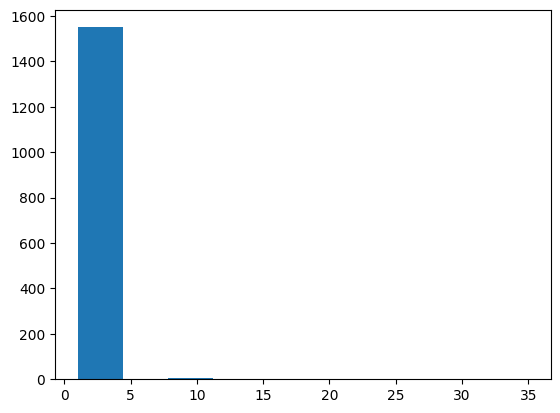

In [84]:
plt.hist(embedding_df['ChapterName'].value_counts())
plt.show()

In [85]:
embedding_df['BookName'].value_counts()

الهوامل والشوامل                                           100
الشهاب الراصد                                               40
ثورة الإسلام وبطل الأنبياء: أبو القاسم محمد بن عبد الله     40
الإمتاع والمؤانسة                                           39
حياة الشرق: دُوله وشعوبه وماضيه وحاضره                      31
                                                          ... 
حسن ونعيمة                                                   1
أسس التفكير العلمي                                           1
مسرحية جمهورية فرحات                                         1
ملك القطن                                                    1
فلسفة الثورة في الميزان                                      1
Name: BookName, Length: 154, dtype: int64

In [86]:
authors = embedding_df['AuthorName'].sort_values().unique().tolist()
author_to_idx_mapping = {author: idx for idx, author in enumerate(authors)}
idx_to_author_mapping = {idx: author for author, idx in author_to_idx_mapping.items()}

In [87]:
class EmbeddingDataset(Dataset):

    def __init__(self, embedding_df: pd.DataFrame, author_name_to_idx_mapping):
        self.embedding_df = embedding_df
        self.author_name_to_idx_mapping = author_name_to_idx_mapping

    def __len__(self):
        return len(self.embedding_df)

    def __getitem__(self, idx):

        row = self.embedding_df.iloc[idx]

        embeddings = row['ChapterTextEmbeddings']
        embeddings = torch.tensor(embeddings)

        label = self.author_name_to_idx_mapping[row['AuthorName']]
        label = torch.tensor(label)

        return embeddings, label

In [88]:
train_df, test_df, _, _ = train_test_split(embedding_df, embedding_df['AuthorName'], test_size=0.3, random_state=42, stratify=embedding_df['AuthorName'])

In [89]:
train_dataset = EmbeddingDataset(train_df, author_to_idx_mapping)
test_dataset = EmbeddingDataset(test_df, author_to_idx_mapping)

In [90]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [91]:
class TextClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_size=512, num_classes=10):
        super(TextClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)  # LayerNorm after the first layer
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.ln2 = nn.LayerNorm(hidden_size // 2)  # LayerNorm after the second layer
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)  # Apply layer normalization
        x = self.relu(x)
        x = self.fc2(x)
        x = self.ln2(x)  # Apply layer normalization
        x = self.relu(x)
        x = self.fc3(x)
        x = torch.softmax(x, dim=-1)
        return x


In [92]:
N_EPOCHS = 500
INPUT_SIZE = 1024
HIDDEN_SIZE = 1024
NUM_CLASSES = len(author_to_idx_mapping)
LEARNING_RATE = 1e-5

In [93]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [94]:
model = TextClassifier(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_classes=NUM_CLASSES).to(device)

In [95]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [96]:
for epoch in range(N_EPOCHS):

    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0

    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        # Zero the parameter gradients
        optimizer.zero_grad()

        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()

    with torch.no_grad():
        model.eval()

        for i, (inputs, labels) in enumerate(test_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()

    print(f"[Epoch {epoch + 1}, train loss: {train_running_loss / len(train_loader.dataset)}, test loss: {test_running_loss / len(test_loader.dataset)}")

print("Finished Training")

100%|██████████| 39/39 [00:00<00:00, 57.72it/s]


[Epoch 1, train loss: 0.07229418929030255, test loss: 0.07231777770952745


100%|██████████| 39/39 [00:00<00:00, 73.75it/s]


[Epoch 2, train loss: 0.06976811730764745, test loss: 0.0692258517850529


100%|██████████| 39/39 [00:00<00:00, 83.05it/s]


[Epoch 3, train loss: 0.06670198576237128, test loss: 0.06668915328654376


100%|██████████| 39/39 [00:00<00:00, 82.51it/s]


[Epoch 4, train loss: 0.06421231690461074, test loss: 0.06448731548858411


100%|██████████| 39/39 [00:00<00:00, 83.30it/s]


[Epoch 5, train loss: 0.06229551584739995, test loss: 0.06291843115380316


100%|██████████| 39/39 [00:00<00:00, 74.52it/s]


[Epoch 6, train loss: 0.0608285337928834, test loss: 0.06160257937330188


100%|██████████| 39/39 [00:00<00:00, 84.25it/s]


[Epoch 7, train loss: 0.05945926991904654, test loss: 0.06056533934492053


100%|██████████| 39/39 [00:00<00:00, 82.81it/s]


[Epoch 8, train loss: 0.058503115080236416, test loss: 0.05972729194344896


100%|██████████| 39/39 [00:00<00:00, 82.41it/s]


[Epoch 9, train loss: 0.05771264157644132, test loss: 0.05913699847279173


100%|██████████| 39/39 [00:00<00:00, 80.83it/s]


[Epoch 10, train loss: 0.056924210331304285, test loss: 0.05857978670886069


100%|██████████| 39/39 [00:00<00:00, 75.46it/s]


[Epoch 11, train loss: 0.05625680626892462, test loss: 0.05811339210380207


100%|██████████| 39/39 [00:00<00:00, 84.63it/s]


[Epoch 12, train loss: 0.0555818028566314, test loss: 0.057548743531559456


100%|██████████| 39/39 [00:00<00:00, 82.24it/s]


[Epoch 13, train loss: 0.054852807812574435, test loss: 0.05700453280499487


100%|██████████| 39/39 [00:00<00:00, 82.58it/s]


[Epoch 14, train loss: 0.05426944930378984, test loss: 0.056633145745956535


100%|██████████| 39/39 [00:00<00:00, 69.91it/s]


[Epoch 15, train loss: 0.05364381210590766, test loss: 0.05630379192756884


100%|██████████| 39/39 [00:00<00:00, 72.22it/s]


[Epoch 16, train loss: 0.05315448414019453, test loss: 0.055926256784887024


100%|██████████| 39/39 [00:00<00:00, 75.58it/s]


[Epoch 17, train loss: 0.052712229596890085, test loss: 0.05561454165162462


100%|██████████| 39/39 [00:00<00:00, 68.37it/s]


[Epoch 18, train loss: 0.052328187275708204, test loss: 0.05532772026278756


100%|██████████| 39/39 [00:00<00:00, 82.44it/s]


[Epoch 19, train loss: 0.05194189403115249, test loss: 0.05507019410530726


100%|██████████| 39/39 [00:00<00:00, 82.70it/s]


[Epoch 20, train loss: 0.05164496821116626, test loss: 0.054720612412149254


100%|██████████| 39/39 [00:00<00:00, 75.17it/s]


[Epoch 21, train loss: 0.051335500507819945, test loss: 0.05464227000872294


100%|██████████| 39/39 [00:00<00:00, 82.29it/s]


[Epoch 22, train loss: 0.05100910469768493, test loss: 0.05439577906420737


100%|██████████| 39/39 [00:00<00:00, 81.49it/s]


[Epoch 23, train loss: 0.050748931295503445, test loss: 0.0543560909502434


100%|██████████| 39/39 [00:00<00:00, 82.95it/s]


[Epoch 24, train loss: 0.05045642629871523, test loss: 0.05412693163662246


100%|██████████| 39/39 [00:00<00:00, 82.74it/s]


[Epoch 25, train loss: 0.05026926470965874, test loss: 0.05404098670591007


100%|██████████| 39/39 [00:00<00:00, 74.04it/s]


[Epoch 26, train loss: 0.05004868313549011, test loss: 0.05373801945736914


100%|██████████| 39/39 [00:00<00:00, 84.07it/s]


[Epoch 27, train loss: 0.04988144044953633, test loss: 0.05367691634279309


100%|██████████| 39/39 [00:00<00:00, 81.80it/s]


[Epoch 28, train loss: 0.04970252135904824, test loss: 0.05350042089368358


100%|██████████| 39/39 [00:00<00:00, 82.44it/s]


[Epoch 29, train loss: 0.04947449114264511, test loss: 0.05348552966659719


100%|██████████| 39/39 [00:00<00:00, 82.54it/s]


[Epoch 30, train loss: 0.04929660442398816, test loss: 0.05345196412368254


100%|██████████| 39/39 [00:00<00:00, 74.43it/s]


[Epoch 31, train loss: 0.049162055709497714, test loss: 0.05323855149926561


100%|██████████| 39/39 [00:00<00:00, 83.68it/s]


[Epoch 32, train loss: 0.0490225377121592, test loss: 0.05315656756812876


100%|██████████| 39/39 [00:00<00:00, 82.62it/s]


[Epoch 33, train loss: 0.048920453563938295, test loss: 0.05320247488491463


100%|██████████| 39/39 [00:00<00:00, 81.05it/s]


[Epoch 34, train loss: 0.04877071409690671, test loss: 0.053049626223968735


100%|██████████| 39/39 [00:00<00:00, 74.27it/s]


[Epoch 35, train loss: 0.0486452777211259, test loss: 0.053007949708086075


100%|██████████| 39/39 [00:00<00:00, 83.90it/s]


[Epoch 36, train loss: 0.048544715187413906, test loss: 0.05280943576133612


100%|██████████| 39/39 [00:00<00:00, 81.59it/s]


[Epoch 37, train loss: 0.0484187274444394, test loss: 0.052783726516998176


100%|██████████| 39/39 [00:00<00:00, 82.79it/s]


[Epoch 38, train loss: 0.04832894404729207, test loss: 0.05267972724907326


100%|██████████| 39/39 [00:00<00:00, 82.02it/s]


[Epoch 39, train loss: 0.048260599907820785, test loss: 0.052644635466012085


100%|██████████| 39/39 [00:00<00:00, 72.63it/s]


[Epoch 40, train loss: 0.04817790452057753, test loss: 0.0525442718556433


100%|██████████| 39/39 [00:00<00:00, 83.87it/s]


[Epoch 41, train loss: 0.048058762104530646, test loss: 0.05245473664818388


100%|██████████| 39/39 [00:00<00:00, 83.16it/s]


[Epoch 42, train loss: 0.047985669655528494, test loss: 0.052466062433791885


100%|██████████| 39/39 [00:00<00:00, 84.01it/s]


[Epoch 43, train loss: 0.047937717282675145, test loss: 0.052338384317629265


100%|██████████| 39/39 [00:00<00:00, 82.94it/s]


[Epoch 44, train loss: 0.047867689287759425, test loss: 0.05239823528311469


100%|██████████| 39/39 [00:00<00:00, 76.04it/s]


[Epoch 45, train loss: 0.047776021511574104, test loss: 0.05232736536047675


100%|██████████| 39/39 [00:00<00:00, 84.11it/s]


[Epoch 46, train loss: 0.04770127418564587, test loss: 0.052142276231086616


100%|██████████| 39/39 [00:00<00:00, 83.86it/s]


[Epoch 47, train loss: 0.04767798321033881, test loss: 0.05207952969905102


100%|██████████| 39/39 [00:00<00:00, 74.45it/s]


[Epoch 48, train loss: 0.047582211242458684, test loss: 0.05213098476330439


100%|██████████| 39/39 [00:00<00:00, 84.52it/s]


[Epoch 49, train loss: 0.04752286265536052, test loss: 0.051987564699216324


100%|██████████| 39/39 [00:00<00:00, 84.37it/s]


[Epoch 50, train loss: 0.04746756863787891, test loss: 0.052120705671382675


100%|██████████| 39/39 [00:00<00:00, 83.86it/s]


[Epoch 51, train loss: 0.047422389480156625, test loss: 0.05194576445854071


100%|██████████| 39/39 [00:00<00:00, 82.71it/s]


[Epoch 52, train loss: 0.04740187763198604, test loss: 0.05198763356064305


100%|██████████| 39/39 [00:00<00:00, 75.26it/s]


[Epoch 53, train loss: 0.04732330359094511, test loss: 0.05191190495635524


100%|██████████| 39/39 [00:00<00:00, 84.63it/s]


[Epoch 54, train loss: 0.047278562987723004, test loss: 0.051848649978637695


100%|██████████| 39/39 [00:00<00:00, 82.98it/s]


[Epoch 55, train loss: 0.04723585272223, test loss: 0.051779979331926865


100%|██████████| 39/39 [00:00<00:00, 82.65it/s]


[Epoch 56, train loss: 0.0472253828513913, test loss: 0.0518613365111929


100%|██████████| 39/39 [00:00<00:00, 82.47it/s]


[Epoch 57, train loss: 0.04716147591428059, test loss: 0.051870331168174744


100%|██████████| 39/39 [00:00<00:00, 76.80it/s]


[Epoch 58, train loss: 0.04712919239106217, test loss: 0.05175231487462015


100%|██████████| 39/39 [00:00<00:00, 83.82it/s]


[Epoch 59, train loss: 0.04710355502803151, test loss: 0.051708428245602234


100%|██████████| 39/39 [00:00<00:00, 83.09it/s]


[Epoch 60, train loss: 0.047069279255905774, test loss: 0.05170215553406513


100%|██████████| 39/39 [00:00<00:00, 75.59it/s]


[Epoch 61, train loss: 0.04703866679493974, test loss: 0.05164042002323902


100%|██████████| 39/39 [00:00<00:00, 84.76it/s]


[Epoch 62, train loss: 0.04701345170416483, test loss: 0.05166547429380995


100%|██████████| 39/39 [00:00<00:00, 83.51it/s]


[Epoch 63, train loss: 0.04698488634776294, test loss: 0.051664728558424744


100%|██████████| 39/39 [00:00<00:00, 80.75it/s]


[Epoch 64, train loss: 0.04696634009601624, test loss: 0.051521031693978744


100%|██████████| 39/39 [00:00<00:00, 83.80it/s]


[Epoch 65, train loss: 0.04694034084071958, test loss: 0.05153756520964883


100%|██████████| 39/39 [00:00<00:00, 75.77it/s]


[Epoch 66, train loss: 0.04691708979567861, test loss: 0.05153013517459234


100%|██████████| 39/39 [00:00<00:00, 84.21it/s]


[Epoch 67, train loss: 0.04689663454769104, test loss: 0.051536003522800675


100%|██████████| 39/39 [00:00<00:00, 83.51it/s]


[Epoch 68, train loss: 0.04686927136366929, test loss: 0.05151171575893055


100%|██████████| 39/39 [00:00<00:00, 83.20it/s]


[Epoch 69, train loss: 0.046850466534374205, test loss: 0.05145243306954702


100%|██████████| 39/39 [00:00<00:00, 83.68it/s]


[Epoch 70, train loss: 0.046835950719631786, test loss: 0.05153429914604534


100%|██████████| 39/39 [00:00<00:00, 77.21it/s]


[Epoch 71, train loss: 0.046814962906566095, test loss: 0.051461403568585716


100%|██████████| 39/39 [00:00<00:00, 84.32it/s]


[Epoch 72, train loss: 0.04679956358622729, test loss: 0.0514480322599411


100%|██████████| 39/39 [00:00<00:00, 81.68it/s]


[Epoch 73, train loss: 0.04678312191149084, test loss: 0.0513892031528733


100%|██████████| 39/39 [00:00<00:00, 75.14it/s]


[Epoch 74, train loss: 0.04677048243158232, test loss: 0.051426786139155876


100%|██████████| 39/39 [00:00<00:00, 84.01it/s]


[Epoch 75, train loss: 0.0467560380454955, test loss: 0.051340431426510666


100%|██████████| 39/39 [00:00<00:00, 84.38it/s]


[Epoch 76, train loss: 0.04673908202628779, test loss: 0.05131764145511569


100%|██████████| 39/39 [00:00<00:00, 83.71it/s]


[Epoch 77, train loss: 0.0467252582069335, test loss: 0.051421442943992035


100%|██████████| 39/39 [00:00<00:00, 75.82it/s]


[Epoch 78, train loss: 0.046711255767481114, test loss: 0.0513601770455187


100%|██████████| 39/39 [00:00<00:00, 84.77it/s]


[Epoch 79, train loss: 0.04669753419674509, test loss: 0.05139963802966205


100%|██████████| 39/39 [00:00<00:00, 84.01it/s]


[Epoch 80, train loss: 0.046683089713740154, test loss: 0.05130717248627634


100%|██████████| 39/39 [00:00<00:00, 82.55it/s]


[Epoch 81, train loss: 0.046672518466546284, test loss: 0.05137377999948733


100%|██████████| 39/39 [00:00<00:00, 83.87it/s]


[Epoch 82, train loss: 0.046663307562106994, test loss: 0.05128202722831206


100%|██████████| 39/39 [00:00<00:00, 83.52it/s]


[Epoch 83, train loss: 0.04665314463095936, test loss: 0.05124064692945191


100%|██████████| 39/39 [00:00<00:00, 77.07it/s]


[Epoch 84, train loss: 0.046644925877330747, test loss: 0.05122393821225022


100%|██████████| 39/39 [00:00<00:00, 83.86it/s]


[Epoch 85, train loss: 0.04663604255614242, test loss: 0.051220794970339


100%|██████████| 39/39 [00:00<00:00, 83.74it/s]


[Epoch 86, train loss: 0.04662953246899736, test loss: 0.05115264292919275


100%|██████████| 39/39 [00:00<00:00, 75.15it/s]


[Epoch 87, train loss: 0.04665332625551922, test loss: 0.05118132337476268


100%|██████████| 39/39 [00:00<00:00, 84.78it/s]


[Epoch 88, train loss: 0.04661615427916612, test loss: 0.05110521930636781


100%|██████████| 39/39 [00:00<00:00, 83.04it/s]


[Epoch 89, train loss: 0.046609527890275164, test loss: 0.05111704902215437


100%|██████████| 39/39 [00:00<00:00, 84.17it/s]


[Epoch 90, train loss: 0.04660358923237498, test loss: 0.051180744487227814


100%|██████████| 39/39 [00:00<00:00, 83.43it/s]


[Epoch 91, train loss: 0.04663196782755658, test loss: 0.05104312639344822


100%|██████████| 39/39 [00:00<00:00, 74.39it/s]


[Epoch 92, train loss: 0.04659216985469911, test loss: 0.051091877122720085


100%|██████████| 39/39 [00:00<00:00, 84.29it/s]


[Epoch 93, train loss: 0.04658749152005203, test loss: 0.05103234088782108


100%|██████████| 39/39 [00:00<00:00, 83.34it/s]


[Epoch 94, train loss: 0.04658229709640751, test loss: 0.051072844501697655


100%|██████████| 39/39 [00:00<00:00, 83.48it/s]


[Epoch 95, train loss: 0.04657741639672256, test loss: 0.05107669961271864


100%|██████████| 39/39 [00:00<00:00, 76.32it/s]


[Epoch 96, train loss: 0.046573412321447356, test loss: 0.05104967138983987


100%|██████████| 39/39 [00:00<00:00, 82.12it/s]


[Epoch 97, train loss: 0.04656872759020426, test loss: 0.05107605615348527


100%|██████████| 39/39 [00:00<00:00, 82.82it/s]


[Epoch 98, train loss: 0.04656396503370952, test loss: 0.05101276256821372


100%|██████████| 39/39 [00:00<00:00, 83.55it/s]


[Epoch 99, train loss: 0.046559811123018345, test loss: 0.0509775314818729


100%|██████████| 39/39 [00:00<00:00, 71.28it/s]


[Epoch 100, train loss: 0.04655634726935286, test loss: 0.05104438576734427


100%|██████████| 39/39 [00:00<00:00, 84.05it/s]


[Epoch 101, train loss: 0.04655103877307923, test loss: 0.0511413033712994


100%|██████████| 39/39 [00:00<00:00, 83.34it/s]


[Epoch 102, train loss: 0.0465441327754075, test loss: 0.05106983740221371


100%|██████████| 39/39 [00:00<00:00, 84.04it/s]


[Epoch 103, train loss: 0.046533404036266046, test loss: 0.05099784424810699


100%|██████████| 39/39 [00:00<00:00, 83.55it/s]


[Epoch 104, train loss: 0.04652456006383508, test loss: 0.050969125872308556


100%|██████████| 39/39 [00:00<00:00, 74.57it/s]


[Epoch 105, train loss: 0.04651999512339026, test loss: 0.05099544064565138


100%|██████████| 39/39 [00:00<00:00, 84.22it/s]


[Epoch 106, train loss: 0.046516235378699575, test loss: 0.050951826978813515


100%|██████████| 39/39 [00:00<00:00, 83.40it/s]


[Epoch 107, train loss: 0.046512191470076396, test loss: 0.05100908875465393


100%|██████████| 39/39 [00:00<00:00, 83.09it/s]


[Epoch 108, train loss: 0.046509523508025376, test loss: 0.0509500526117556


100%|██████████| 39/39 [00:00<00:00, 70.42it/s]


[Epoch 109, train loss: 0.04650555034963096, test loss: 0.05095210016676874


100%|██████████| 39/39 [00:00<00:00, 84.94it/s]


[Epoch 110, train loss: 0.04650298986977678, test loss: 0.05097536742687225


100%|██████████| 39/39 [00:00<00:00, 83.25it/s]


[Epoch 111, train loss: 0.04650025290202319, test loss: 0.050872491841966454


100%|██████████| 39/39 [00:00<00:00, 83.48it/s]


[Epoch 112, train loss: 0.046497414460996304, test loss: 0.05087132029461138


100%|██████████| 39/39 [00:00<00:00, 81.80it/s]


[Epoch 113, train loss: 0.046494984239097537, test loss: 0.0508650340365641


100%|██████████| 39/39 [00:00<00:00, 75.69it/s]


[Epoch 114, train loss: 0.046492623313655695, test loss: 0.05090460339278886


100%|██████████| 39/39 [00:00<00:00, 84.42it/s]


[Epoch 115, train loss: 0.046489282158332146, test loss: 0.050882378085093063


100%|██████████| 39/39 [00:00<00:00, 84.24it/s]


[Epoch 116, train loss: 0.046487689405921996, test loss: 0.05095017114371964


100%|██████████| 39/39 [00:00<00:00, 82.95it/s]


[Epoch 117, train loss: 0.04648567496276483, test loss: 0.05092592898643378


100%|██████████| 39/39 [00:00<00:00, 75.14it/s]


[Epoch 118, train loss: 0.04648299081538751, test loss: 0.05090774166764635


100%|██████████| 39/39 [00:00<00:00, 85.75it/s]


[Epoch 119, train loss: 0.04648091550764999, test loss: 0.05091009108406125


100%|██████████| 39/39 [00:00<00:00, 84.14it/s]


[Epoch 120, train loss: 0.046479191721939456, test loss: 0.05084796565951723


100%|██████████| 39/39 [00:00<00:00, 81.97it/s]


[Epoch 121, train loss: 0.04647699749566675, test loss: 0.0508574362505566


100%|██████████| 39/39 [00:00<00:00, 84.20it/s]


[Epoch 122, train loss: 0.046475223312532996, test loss: 0.05096594402284333


100%|██████████| 39/39 [00:00<00:00, 75.40it/s]


[Epoch 123, train loss: 0.04647345155235229, test loss: 0.05077968018524574


100%|██████████| 39/39 [00:00<00:00, 84.56it/s]


[Epoch 124, train loss: 0.04647180501038466, test loss: 0.050872600665598205


100%|██████████| 39/39 [00:00<00:00, 83.59it/s]


[Epoch 125, train loss: 0.046469920825182906, test loss: 0.05089097312002471


100%|██████████| 39/39 [00:00<00:00, 83.62it/s]


[Epoch 126, train loss: 0.046468413651474125, test loss: 0.050785287085807686


100%|██████████| 39/39 [00:00<00:00, 84.35it/s]


[Epoch 127, train loss: 0.04646645745610803, test loss: 0.050770306225978966


100%|██████████| 39/39 [00:00<00:00, 83.14it/s]


[Epoch 128, train loss: 0.046464698198365004, test loss: 0.05081149393861944


100%|██████████| 39/39 [00:00<00:00, 73.44it/s]


[Epoch 129, train loss: 0.046463668540241275, test loss: 0.05069022061246814


100%|██████████| 39/39 [00:00<00:00, 83.64it/s]


[Epoch 130, train loss: 0.046461956578541574, test loss: 0.050889428817864624


100%|██████████| 39/39 [00:00<00:00, 84.23it/s]


[Epoch 131, train loss: 0.04646040889305797, test loss: 0.050743641275348084


100%|██████████| 39/39 [00:00<00:00, 84.03it/s]


[Epoch 132, train loss: 0.04645922358443098, test loss: 0.050714581979043556


100%|██████████| 39/39 [00:00<00:00, 77.39it/s]


[Epoch 133, train loss: 0.046457702163758316, test loss: 0.0507324809829394


100%|██████████| 39/39 [00:00<00:00, 82.80it/s]


[Epoch 134, train loss: 0.04645631991750826, test loss: 0.050719448562824364


100%|██████████| 39/39 [00:00<00:00, 82.56it/s]


[Epoch 135, train loss: 0.04645530537861149, test loss: 0.05067369635358001


100%|██████████| 39/39 [00:00<00:00, 75.14it/s]


[Epoch 136, train loss: 0.046454114351815325, test loss: 0.0508130689462026


100%|██████████| 39/39 [00:00<00:00, 83.50it/s]


[Epoch 137, train loss: 0.04645298990776869, test loss: 0.050647820035616554


100%|██████████| 39/39 [00:00<00:00, 84.08it/s]


[Epoch 138, train loss: 0.046451696923108604, test loss: 0.05087790118925499


100%|██████████| 39/39 [00:00<00:00, 83.95it/s]


[Epoch 139, train loss: 0.046450415568623116, test loss: 0.050642152401533996


100%|██████████| 39/39 [00:00<00:00, 76.86it/s]


[Epoch 140, train loss: 0.046449639448305456, test loss: 0.05079892751845447


100%|██████████| 39/39 [00:00<00:00, 84.53it/s]


[Epoch 141, train loss: 0.046448199438854934, test loss: 0.05080785737796263


100%|██████████| 39/39 [00:00<00:00, 83.39it/s]


[Epoch 142, train loss: 0.046447325237398224, test loss: 0.050733021488695434


100%|██████████| 39/39 [00:00<00:00, 84.23it/s]


[Epoch 143, train loss: 0.046446329112944565, test loss: 0.0507231792717269


100%|██████████| 39/39 [00:00<00:00, 75.31it/s]


[Epoch 144, train loss: 0.04644542738674133, test loss: 0.05068344713160486


100%|██████████| 39/39 [00:00<00:00, 82.31it/s]


[Epoch 145, train loss: 0.04644435527848034, test loss: 0.05066466760454756


100%|██████████| 39/39 [00:00<00:00, 83.24it/s]


[Epoch 146, train loss: 0.04644330139082622, test loss: 0.050678675824945625


100%|██████████| 39/39 [00:00<00:00, 82.63it/s]


[Epoch 147, train loss: 0.04644247128711483, test loss: 0.050641165764042824


100%|██████████| 39/39 [00:00<00:00, 82.44it/s]


[Epoch 148, train loss: 0.04644147593800615, test loss: 0.05063605827815605


100%|██████████| 39/39 [00:00<00:00, 74.33it/s]


[Epoch 149, train loss: 0.046440675491239966, test loss: 0.050687445384083374


100%|██████████| 39/39 [00:00<00:00, 83.11it/s]


[Epoch 150, train loss: 0.04643980681411619, test loss: 0.05063878202980215


100%|██████████| 39/39 [00:00<00:00, 81.57it/s]


[Epoch 151, train loss: 0.0464391535859767, test loss: 0.050642278384078636


100%|██████████| 39/39 [00:00<00:00, 81.29it/s]


[Epoch 152, train loss: 0.04643824052035324, test loss: 0.050634692564155113


100%|██████████| 39/39 [00:00<00:00, 68.90it/s]


[Epoch 153, train loss: 0.0464375964994353, test loss: 0.0506181407606963


100%|██████████| 39/39 [00:00<00:00, 83.58it/s]


[Epoch 154, train loss: 0.04643667810331515, test loss: 0.05061705410480499


100%|██████████| 39/39 [00:00<00:00, 83.16it/s]


[Epoch 155, train loss: 0.04643586525102941, test loss: 0.0506364366773403


100%|██████████| 39/39 [00:00<00:00, 83.04it/s]


[Epoch 156, train loss: 0.04643509310435474, test loss: 0.05054747380993583


100%|██████████| 39/39 [00:00<00:00, 82.75it/s]


[Epoch 157, train loss: 0.04643470785482143, test loss: 0.050682457333261315


100%|██████████| 39/39 [00:00<00:00, 74.75it/s]


[Epoch 158, train loss: 0.04643383045506671, test loss: 0.05058551060430931


100%|██████████| 39/39 [00:00<00:00, 83.59it/s]


[Epoch 159, train loss: 0.04643316685668821, test loss: 0.05066911673003977


100%|██████████| 39/39 [00:00<00:00, 82.14it/s]


[Epoch 160, train loss: 0.04643260851138976, test loss: 0.050557312414501655


100%|██████████| 39/39 [00:00<00:00, 82.53it/s]


[Epoch 161, train loss: 0.04643182715749353, test loss: 0.05068514992793401


100%|██████████| 39/39 [00:00<00:00, 83.34it/s]


[Epoch 162, train loss: 0.04646388815670478, test loss: 0.050552501822962906


100%|██████████| 39/39 [00:00<00:00, 74.48it/s]


[Epoch 163, train loss: 0.046430750881753316, test loss: 0.05062908972754623


100%|██████████| 39/39 [00:00<00:00, 83.98it/s]


[Epoch 164, train loss: 0.04643003165237303, test loss: 0.05060572222326741


100%|██████████| 39/39 [00:00<00:00, 83.63it/s]


[Epoch 165, train loss: 0.04642974748844054, test loss: 0.05063964945800377


100%|██████████| 39/39 [00:00<00:00, 83.50it/s]


[Epoch 166, train loss: 0.04642900083123184, test loss: 0.05051806704564528


100%|██████████| 39/39 [00:00<00:00, 83.69it/s]


[Epoch 167, train loss: 0.04642855239108326, test loss: 0.05055451912410332


100%|██████████| 39/39 [00:00<00:00, 76.16it/s]


[Epoch 168, train loss: 0.04642807787995998, test loss: 0.050522177959933426


100%|██████████| 39/39 [00:00<00:00, 85.07it/s]


[Epoch 169, train loss: 0.04642761858498178, test loss: 0.0505138762069471


100%|██████████| 39/39 [00:00<00:00, 84.20it/s]


[Epoch 170, train loss: 0.0464268657250133, test loss: 0.05051674648667827


100%|██████████| 39/39 [00:00<00:00, 82.51it/s]


[Epoch 171, train loss: 0.046426481735415574, test loss: 0.0504966163725564


100%|██████████| 39/39 [00:00<00:00, 75.89it/s]


[Epoch 172, train loss: 0.0464260835957721, test loss: 0.050551110370592636


100%|██████████| 39/39 [00:00<00:00, 65.98it/s]


[Epoch 173, train loss: 0.04642554647554227, test loss: 0.050538893450390206


100%|██████████| 39/39 [00:00<00:00, 75.54it/s]


[Epoch 174, train loss: 0.04642510607959778, test loss: 0.050494340558846794


100%|██████████| 39/39 [00:00<00:00, 75.00it/s]


[Epoch 175, train loss: 0.04642453978701336, test loss: 0.050475803965871986


100%|██████████| 39/39 [00:00<00:00, 63.39it/s]


[Epoch 176, train loss: 0.04642422150790207, test loss: 0.050509024524327484


100%|██████████| 39/39 [00:00<00:00, 80.07it/s]


[Epoch 177, train loss: 0.04642380485689737, test loss: 0.050559796167142464


100%|██████████| 39/39 [00:00<00:00, 80.75it/s]


[Epoch 178, train loss: 0.04642324282871029, test loss: 0.050514042151696754


100%|██████████| 39/39 [00:00<00:00, 73.58it/s]


[Epoch 179, train loss: 0.04642285350861588, test loss: 0.05053554723660151


100%|██████████| 39/39 [00:00<00:00, 82.25it/s]


[Epoch 180, train loss: 0.046422513229090995, test loss: 0.05046613288648201


100%|██████████| 39/39 [00:00<00:00, 80.41it/s]


[Epoch 181, train loss: 0.046422103265436686, test loss: 0.0505328918948318


100%|██████████| 39/39 [00:00<00:00, 81.19it/s]


[Epoch 182, train loss: 0.04642169262335553, test loss: 0.050506767675732124


100%|██████████| 39/39 [00:00<00:00, 73.01it/s]


[Epoch 183, train loss: 0.046421394987804135, test loss: 0.050527784183169853


100%|██████████| 39/39 [00:00<00:00, 82.17it/s]


[Epoch 184, train loss: 0.046421036972263, test loss: 0.050434615575906006


100%|██████████| 39/39 [00:00<00:00, 82.34it/s]


[Epoch 185, train loss: 0.046420680798166164, test loss: 0.05042916175090906


100%|██████████| 39/39 [00:00<00:00, 73.31it/s]


[Epoch 186, train loss: 0.04642028643832943, test loss: 0.05048047299637939


100%|██████████| 39/39 [00:00<00:00, 81.79it/s]


[Epoch 187, train loss: 0.046420059359170554, test loss: 0.05043876735549985


100%|██████████| 39/39 [00:00<00:00, 80.00it/s]


[Epoch 188, train loss: 0.046419652981486745, test loss: 0.05054850921486363


100%|██████████| 39/39 [00:00<00:00, 80.20it/s]


[Epoch 189, train loss: 0.04641935457059038, test loss: 0.050499780385783226


100%|██████████| 39/39 [00:00<00:00, 69.52it/s]


[Epoch 190, train loss: 0.04641909957901249, test loss: 0.050480924998268936


100%|██████████| 39/39 [00:00<00:00, 81.91it/s]


[Epoch 191, train loss: 0.04641879196089458, test loss: 0.05046334998174147


100%|██████████| 39/39 [00:00<00:00, 81.48it/s]


[Epoch 192, train loss: 0.04641850188495667, test loss: 0.0504252321340821


100%|██████████| 39/39 [00:00<00:00, 81.75it/s]


[Epoch 193, train loss: 0.04641812690874425, test loss: 0.050438358250892525


100%|██████████| 39/39 [00:00<00:00, 67.62it/s]


[Epoch 194, train loss: 0.0464178949836793, test loss: 0.05059130106008414


100%|██████████| 39/39 [00:00<00:00, 78.56it/s]


[Epoch 195, train loss: 0.04641766945521037, test loss: 0.050486323056798996


100%|██████████| 39/39 [00:00<00:00, 80.91it/s]


[Epoch 196, train loss: 0.046417390718692685, test loss: 0.050409771050467636


100%|██████████| 39/39 [00:00<00:00, 81.16it/s]


[Epoch 197, train loss: 0.046417092792386934, test loss: 0.05055795451908401


100%|██████████| 39/39 [00:00<00:00, 76.56it/s]


[Epoch 198, train loss: 0.04641683915766274, test loss: 0.05041234985445485


100%|██████████| 39/39 [00:00<00:00, 81.12it/s]


[Epoch 199, train loss: 0.0464492279339612, test loss: 0.05054896099097801


100%|██████████| 39/39 [00:00<00:00, 79.81it/s]


[Epoch 200, train loss: 0.04641636144824144, test loss: 0.05042233521288091


100%|██████████| 39/39 [00:00<00:00, 73.04it/s]


[Epoch 201, train loss: 0.04641612758481405, test loss: 0.05036591535264796


100%|██████████| 39/39 [00:00<00:00, 79.02it/s]


[Epoch 202, train loss: 0.04641590728992369, test loss: 0.05051917989145626


100%|██████████| 39/39 [00:00<00:00, 81.47it/s]


[Epoch 203, train loss: 0.04641571762115975, test loss: 0.0504652512344447


100%|██████████| 39/39 [00:00<00:00, 73.74it/s]


[Epoch 204, train loss: 0.046415433263391016, test loss: 0.05043708465316079


100%|██████████| 39/39 [00:00<00:00, 81.53it/s]


[Epoch 205, train loss: 0.04641522915382695, test loss: 0.050409022605780396


100%|██████████| 39/39 [00:00<00:00, 80.44it/s]


[Epoch 206, train loss: 0.046415002559258685, test loss: 0.05037436002131664


100%|██████████| 39/39 [00:00<00:00, 73.39it/s]


[Epoch 207, train loss: 0.04641480348943695, test loss: 0.05034319559733073


100%|██████████| 39/39 [00:00<00:00, 82.56it/s]


[Epoch 208, train loss: 0.04641457505342437, test loss: 0.05035438433741078


100%|██████████| 39/39 [00:00<00:00, 79.10it/s]


[Epoch 209, train loss: 0.0464144584609241, test loss: 0.05042699159997882


100%|██████████| 39/39 [00:00<00:00, 81.22it/s]


[Epoch 210, train loss: 0.0464141859271662, test loss: 0.05039171761635578


100%|██████████| 39/39 [00:00<00:00, 73.86it/s]


[Epoch 211, train loss: 0.04641403037358106, test loss: 0.050401819248994194


100%|██████████| 39/39 [00:00<00:00, 81.84it/s]


[Epoch 212, train loss: 0.04641387191245226, test loss: 0.050369762561538


100%|██████████| 39/39 [00:00<00:00, 81.54it/s]


[Epoch 213, train loss: 0.04641365374976057, test loss: 0.05042594987334627


100%|██████████| 39/39 [00:00<00:00, 73.02it/s]


[Epoch 214, train loss: 0.04641348714750957, test loss: 0.05034411653424754


100%|██████████| 39/39 [00:00<00:00, 82.25it/s]


[Epoch 215, train loss: 0.046413303584587284, test loss: 0.05037025475140774


100%|██████████| 39/39 [00:00<00:00, 79.18it/s]


[Epoch 216, train loss: 0.04641313901761683, test loss: 0.05031834745948965


100%|██████████| 39/39 [00:00<00:00, 81.08it/s]


[Epoch 217, train loss: 0.04641295874991068, test loss: 0.050335695571971664


100%|██████████| 39/39 [00:00<00:00, 80.49it/s]


[Epoch 218, train loss: 0.04641282568132974, test loss: 0.05041367244539839


100%|██████████| 39/39 [00:00<00:00, 76.42it/s]


[Epoch 219, train loss: 0.0464126423122437, test loss: 0.05041677504777908


100%|██████████| 39/39 [00:00<00:00, 81.73it/s]


[Epoch 220, train loss: 0.046412516706358126, test loss: 0.050531596171133446


100%|██████████| 39/39 [00:00<00:00, 80.01it/s]


[Epoch 221, train loss: 0.04641233188350026, test loss: 0.05039998550306667


100%|██████████| 39/39 [00:00<00:00, 73.56it/s]


[Epoch 222, train loss: 0.04641220666528717, test loss: 0.05048262643994707


100%|██████████| 39/39 [00:00<00:00, 80.72it/s]


[Epoch 223, train loss: 0.04641204645963219, test loss: 0.05036654052409259


100%|██████████| 39/39 [00:00<00:00, 79.73it/s]


[Epoch 224, train loss: 0.046411882668006714, test loss: 0.05042066786325339


100%|██████████| 39/39 [00:00<00:00, 73.44it/s]


[Epoch 225, train loss: 0.04641178041938844, test loss: 0.050433389390959885


100%|██████████| 39/39 [00:00<00:00, 81.75it/s]


[Epoch 226, train loss: 0.04641164424942761, test loss: 0.05045174604112452


100%|██████████| 39/39 [00:00<00:00, 80.61it/s]


[Epoch 227, train loss: 0.04641150614110435, test loss: 0.050303341087066765


100%|██████████| 39/39 [00:00<00:00, 73.76it/s]


[Epoch 228, train loss: 0.04641137064957037, test loss: 0.050452832245465484


100%|██████████| 39/39 [00:00<00:00, 82.62it/s]


[Epoch 229, train loss: 0.046411249211164025, test loss: 0.05033609474247152


100%|██████████| 39/39 [00:00<00:00, 79.48it/s]


[Epoch 230, train loss: 0.046411107226115904, test loss: 0.050415526285316


100%|██████████| 39/39 [00:00<00:00, 81.61it/s]


[Epoch 231, train loss: 0.0464109774527511, test loss: 0.0502846846074769


100%|██████████| 39/39 [00:00<00:00, 73.58it/s]


[Epoch 232, train loss: 0.0464108580496253, test loss: 0.05029058366110831


100%|██████████| 39/39 [00:00<00:00, 80.70it/s]


[Epoch 233, train loss: 0.04644340092573709, test loss: 0.050364866852760315


100%|██████████| 39/39 [00:00<00:00, 80.91it/s]


[Epoch 234, train loss: 0.046410602573456805, test loss: 0.05030830272219398


100%|██████████| 39/39 [00:00<00:00, 81.31it/s]


[Epoch 235, train loss: 0.04641048588403841, test loss: 0.05044317313215949


100%|██████████| 39/39 [00:00<00:00, 70.78it/s]


[Epoch 236, train loss: 0.04641034331748156, test loss: 0.05030497886014707


100%|██████████| 39/39 [00:00<00:00, 79.82it/s]


[Epoch 237, train loss: 0.046409981328297434, test loss: 0.050382524502999855


100%|██████████| 39/39 [00:00<00:00, 76.62it/s]


[Epoch 238, train loss: 0.046406480258073264, test loss: 0.050390057265758514


100%|██████████| 39/39 [00:00<00:00, 74.13it/s]


[Epoch 239, train loss: 0.04638725461029425, test loss: 0.05025377305168094


100%|██████████| 39/39 [00:00<00:00, 82.04it/s]


[Epoch 240, train loss: 0.046385453387004574, test loss: 0.050456765700470314


100%|██████████| 39/39 [00:00<00:00, 81.22it/s]


[Epoch 241, train loss: 0.04638509585605404, test loss: 0.05043902135256565


100%|██████████| 39/39 [00:00<00:00, 80.49it/s]


[Epoch 242, train loss: 0.04638490560578137, test loss: 0.050308447895628036


100%|██████████| 39/39 [00:00<00:00, 72.90it/s]


[Epoch 243, train loss: 0.04638474433402705, test loss: 0.050369322074182106


100%|██████████| 39/39 [00:00<00:00, 79.15it/s]


[Epoch 244, train loss: 0.04638459217257616, test loss: 0.05033774019190759


100%|██████████| 39/39 [00:00<00:00, 81.24it/s]


[Epoch 245, train loss: 0.046384483042771256, test loss: 0.050255207852883774


100%|██████████| 39/39 [00:00<00:00, 76.74it/s]


[Epoch 246, train loss: 0.04638438011572613, test loss: 0.05033497738115715


100%|██████████| 39/39 [00:00<00:00, 73.47it/s]


[Epoch 247, train loss: 0.046384274571891725, test loss: 0.050412102179093796


100%|██████████| 39/39 [00:00<00:00, 80.17it/s]


[Epoch 248, train loss: 0.04638416234070693, test loss: 0.050361664457754654


100%|██████████| 39/39 [00:00<00:00, 80.36it/s]


[Epoch 249, train loss: 0.04638405873523495, test loss: 0.05024553270954074


100%|██████████| 39/39 [00:00<00:00, 72.93it/s]


[Epoch 250, train loss: 0.04638396995823558, test loss: 0.05031888886834636


100%|██████████| 39/39 [00:00<00:00, 78.78it/s]


[Epoch 251, train loss: 0.04638387178017841, test loss: 0.0504054862892989


100%|██████████| 39/39 [00:00<00:00, 75.86it/s]


[Epoch 252, train loss: 0.04638379143505562, test loss: 0.0503555771076318


100%|██████████| 39/39 [00:00<00:00, 70.07it/s]


[Epoch 253, train loss: 0.046383719037218794, test loss: 0.0503771494735371


100%|██████████| 39/39 [00:00<00:00, 84.05it/s]


[Epoch 254, train loss: 0.0463836414058034, test loss: 0.050258219919421455


100%|██████████| 39/39 [00:00<00:00, 80.91it/s]


[Epoch 255, train loss: 0.0463835412893838, test loss: 0.050279025101300445


100%|██████████| 39/39 [00:00<00:00, 73.27it/s]


[Epoch 256, train loss: 0.046383454159992496, test loss: 0.05040455451517394


 77%|███████▋  | 30/39 [00:00<00:00, 78.95it/s]


KeyboardInterrupt: 

In [97]:
predicted_labels = []
actual_labels = []

with torch.no_grad():
    model.eval()
    for embedding, label in test_dataset:

        embedding = embedding.unsqueeze(0).to(device)
        output = model(embedding)
        predicted_label = torch.argmax(output, dim=1)[0].cpu().item()

        actual_labels.append(label)
        predicted_labels.append(predicted_label)

In [98]:
(np.array(actual_labels) == np.array(predicted_labels)).sum()/len(actual_labels)

0.9071969696969697

In [99]:
torch.save(model.state_dict(), 'author_classifier_head_jina_embeddings.pt')

In [100]:
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)